In [1]:
# for reading orignal data
# !pip install opencv-python
# !pip install pydicom
# !pip install python-gdcm
# !pip install pycimg
# !pip install napari
# !pip install nibabel

# For marching_cubes
# !pip install numpy-stl
# !pip install fast-simplification
# !pip install SimpleITK

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import nibabel as nib
import numpy as np
import glob
import pydicom
import matplotlib.pyplot as plt
import os
import cv2
import json

In [4]:
# import stl
import pyvista as pv
# import SimpleITK as sitk
import fast_simplification

from scipy.ndimage      import label
from skimage.measure    import marching_cubes

In [5]:
import SimpleITK as sitk
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import napari

In [6]:
# !pip install pymeshfix
# import pymeshfix as mf

In [6]:
class reading_orignal_data:
    
    def __init__(self, MAIN_PATH,SUB_PATH={"CT_PATH":'/CT/',"RT_PATH":'/RTStruct/',}):

        self.INPUT_DIRECTORY = sorted(glob.glob(MAIN_PATH))
        self.PTV_IMAGES = []
        self.CT_SCAN_IMAGES = []

        for frakDir in self.INPUT_DIRECTORY: 

            ctDir     = frakDir + SUB_PATH["CT_PATH"]

            StructDicomFileName = glob.glob(frakDir+ SUB_PATH["RT_PATH"]+ '/*')[0]
            roiId=next((roi[0] for roi in self.displayStructureIDs(StructDicomFileName) if roi[1].lower() == "ptv"),None)
    
            if roiId !=None:
                _,ct = self.readDICOM3D(ctDir)
                cnt  = self.drawContours(ct.shape,roiId,ctDir,StructDicomFileName)

                cnt[cnt>0] = 1

                self.PTV_IMAGES.append(cnt)
                self.CT_SCAN_IMAGES.append(ct)

    def readDICOM3D(self,DICOM_DIR):
        dicomFiles = [file for file in os.listdir(DICOM_DIR) if file.endswith('dcm') and file.startswith('CT')]
        dicoms = []
        for file in dicomFiles:
            ds = pydicom.dcmread(DICOM_DIR+file)
            dicoms.append((DICOM_DIR+file,int(ds[0x0020,0x0013].value)))
        dicoms = sorted(dicoms, key=lambda x: x[1])

        im3D = []
        slicePositions = []
        for d in dicoms:
            ds = pydicom.dcmread(d[0])
            slicePositions.append(ds.ImagePositionPatient[2])
            im3D.append(ds.pixel_array)
    
        im3D = np.asarray(im3D,dtype=np.int16)
        im3D = np.swapaxes(im3D,0,1)
        im3D = np.swapaxes(im3D,1,2)

        ds = pydicom.dcmread(dicoms[0][0])
        CTOrigin = ds.ImagePositionPatient
        CTPixelSize = ds.PixelSpacing
        CTSliceThickness = ds.SliceThickness

        grid = (np.arange(CTOrigin[1],CTOrigin[1]+CTPixelSize[1]*im3D.shape[0],CTPixelSize[1]),
                np.arange(CTOrigin[0],CTOrigin[0]+CTPixelSize[0]*im3D.shape[1],CTPixelSize[0]),
                np.asarray(slicePositions,dtype=np.float64))
    
        return grid,im3D
    
    def displayStructureIDs(self,structuresFile):
        ROINumbers = []
        ds = pydicom.dcmread(structuresFile)
        for _,struct in enumerate(ds.StructureSetROISequence):
            ROINumbers.append((struct.ROINumber,struct.ROIName))
        return ROINumbers
    
    def drawContours(self,imSize,roiID,pathToCT,structuresDicomFileName):

        ds = pydicom.dcmread(structuresDicomFileName)

        roiNumbers = [dum.ROINumber for dum in ds.StructureSetROISequence]
        structID = roiNumbers.index(roiID)
    

        assert ds.SOPClassUID == "1.2.840.10008.5.1.4.1.1.481.3", "This is not a Dicom Structure file"

        ROI = [
            ds.ROIContourSequence[u].ContourSequence for u in range(len(ds.ROIContourSequence)) 
                if ds.ROIContourSequence[u].ReferencedROINumber == ds.StructureSetROISequence[structID].ROINumber
        ][0]

        positions = []
        CTs = glob.glob(pathToCT + '/CT*.dcm')
        for fname in CTs:
            ctds = pydicom.dcmread(fname)
            positions.append((ctds.ImagePositionPatient[2],fname)) 
            
        positions = sorted(positions, key=lambda x: x[0])  
        delta = positions[1][0] - positions[0][0]

        dum = np.zeros(imSize,dtype=np.uint8)
    
        for seq in ROI:
            points = np.swapaxes(np.reshape(seq.ContourData,(-1,3)),0,1)
            pos = points[2,0]
            for p in positions:
                if abs(pos - p[0]) < delta/2:
                    fname = p[1]     
            dicImage = pydicom.dcmread(fname)
        

            M = np.zeros((3,3),dtype = np.float32)
            M[0,0] = dicImage[0x0020, 0x0037].value[1]* dicImage[0x0028, 0x0030].value[0]
            M[1,0] = dicImage[0x0020, 0x0037].value[0]* dicImage[0x0028, 0x0030].value[0]
            M[0,1] = dicImage[0x0020, 0x0037].value[4]* dicImage[0x0028, 0x0030].value[1]
            M[1,1] = dicImage[0x0020, 0x0037].value[3]* dicImage[0x0028, 0x0030].value[1]
            M[0,2] = dicImage[0x0020, 0x0032].value[0]
            M[1,2] = dicImage[0x0020, 0x0032].value[1]
            M[2,2] = 1.0
        
            M = np.linalg.inv(M)
            points[2,:].fill(1)
            points = np.dot(M,points)[:2,:]

            big = int(ds.StructureSetROISequence[structID].ROINumber) # 255
            CTSlice = int(dicImage[0x0020,0x0013].value)-1            # numery sliców w Dicom startują od 1
            dum2D = np.zeros(imSize[0:2],dtype=np.uint8)
            for id in range(points.shape[1]-1):
                cv2.line(dum2D,(int(points[1,id]),int(points[0,id])),(int(points[1,id+1]),int(points[0,id+1])),big,1)
            cv2.line(dum2D,(int(points[1,points.shape[1]-1]),int(points[0,points.shape[1]-1])),(int(points[1,0]),int(points[0,0])),big,1)

            dum[dum2D!=0,CTSlice] = dum2D[dum2D!=0]
        
        for sl in range(dum.shape[2]):
            im_flood_fill = dum[...,sl].copy()
            h, w = dum.shape[:2]
            mask = np.zeros((h + 2, w + 2), np.uint8)
            im_flood_fill = im_flood_fill.astype("uint8")
            cv2.floodFill(im_flood_fill, mask, (0, 0), 128)
            dum[im_flood_fill!=128,sl] = big
        
        return dum
    
    @staticmethod
    def saveImage(PATH,LABEL,IMAGES):
        aff = np.eye(4)
        for INDEX,IMG in enumerate(IMAGES):
            baseName = PATH + LABEL + str(INDEX) + '_.nii.gz'
            niftiImage = nib.Nifti1Image(IMG, affine=aff)
            nib.save(niftiImage,baseName)
            
    def get_PTV_IMAGES(self):
        return self.PTV_IMAGES
    
    def get_CT_SCAN_IMAGES(self):
        return self.CT_SCAN_IMAGES

In [6]:
class reducing_point_numbers:

    def __init__(self, IMAGE):
        self.IMAGE=IMAGE
        self.mc()

    def mc(self):
        self.VERTS, self.FACES, _, _ = marching_cubes(self.IMAGE)
        self.MC_IMAGE = pv.PolyData(self.VERTS).delaunay_3d().extract_surface()

    def show_march_cube(self,IMG):
        p = pv.Plotter(notebook=True)
        p.add_mesh(IMG, color="tan", show_edges=False)
        p.show()

    def calculate_decimate(self,TYPE=1, DECIMATION_FACTOR = 0.95):
        # create mesh from marchibng cubes data
        sizes = np.array([3]*self.FACES.shape[0],dtype=np.int32).reshape((-1,1))
        # print(sizes.shape, sizes[:2])

        facesForMesh = np.concatenate((sizes,self.FACES),axis = 1)
        mesh = pv.PolyData(self.VERTS, facesForMesh)

        if TYPE==1:
          newMesh = mesh.decimate(DECIMATION_FACTOR)
        elif TYPE==2:
          newMesh = mesh.decimate_pro(DECIMATION_FACTOR)
        elif TYPE==3:
          newMesh=fast_simplification.simplify_mesh(mesh, target_reduction=DECIMATION_FACTOR)

        # newMesh = mf.MeshFix(newMesh)
        # newMesh.repair(verbose=True)
        # newMesh.plot(screenshot='meshfix.png')

        density = 1
        x_min, x_max, y_min, y_max, z_min, z_max = 0, self.IMAGE.shape[0], 0 , self.IMAGE.shape[1],0, self.IMAGE.shape[2]
        x = np.arange(x_min, x_max, density)
        y = np.arange(y_min, y_max, density)
        z = np.arange(z_min, z_max, density)
        x, y, z = np.meshgrid(x, y, z)

        grid = pv.StructuredGrid(x, y, z)

        selection = grid.select_enclosed_points(newMesh.extract_surface(),tolerance=0.0,check_surface=False)

        mask = selection.point_data['SelectedPoints'].view(np.uint8)

        # convert the mask to the original shape of the object image
        generated_mask = mask.reshape((x.shape[2],x.shape[1], x.shape[0]))
        generated_mask = np.swapaxes(generated_mask,0,2)
        generated_mask = np.swapaxes(generated_mask,0,1)

        # do some cleaning - postprocessing
        # debrils removal
        for sl in range(generated_mask.shape[2]):
            if np.sum(generated_mask[:,:,sl]):
                labels,_ = label(generated_mask[:,:,sl])
                ids,counts = np.unique(labels,return_counts=True)
                ids = ids[1:]
                counts = counts[1:]
                idmax = np.argmax(counts)
                generated_mask[:,:,sl][labels!=ids[idmax]] = 0

        # hole filling
        for sl in range(generated_mask.shape[2]):
            if np.sum(generated_mask[:,:,sl]):
                labels,_ = label(1 - generated_mask[:,:,sl])
                ids,counts = np.unique(labels,return_counts=True)
                idmax = np.argmax(counts)
                #print(ids,counts)
                generated_mask[:,:,sl][labels!=ids[idmax]] = 1
                #break
        self.NEW_IMAGE=newMesh
        self.MASK=generated_mask

    def dc_dice(self):
        # check agreement between initial mask and recreated mask - DC is Dice's similarity coefficient, which should be as close to 1 as possible
        return 2*np.sum(self.MASK*self.IMAGE)/(np.sum(self.IMAGE) + np.sum(self.MASK))
    
    def get_new_image(self):
        return self.NEW_IMAGE
    
    def get_mc_image(self):
        return self.MC_IMAGE
    
    def get_mc_mask(self):
        return self.MASK
    
    def get_landmarks(self):
        return self.VERTS

In [7]:
class registration:

    def __init__(self, MOVING_MASK,FIXED_MASK):
        self.MOVING_MASK=MOVING_MASK
        self.FIXED_MASK=FIXED_MASK
        self.registration_exec()

    def smooth_and_resample(self,image, shrink_factor, smoothing_sigma):
        """
            Args:
                image: The image we want to resample.
                shrink_factor: A number greater than one, such that the new image's size is original_size/shrink_factor.
                smoothing_sigma: Sigma for Gaussian smoothing, this is in physical (image spacing) units, not pixels.
            Return:
                Image which is a result of smoothing the input and then resampling it using the given sigma and shrink factor.
        """
        smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigma)

        original_spacing = image.GetSpacing()
        original_size    = image.GetSize()

        new_size    = [int(sz/float(shrink_factor) + 0.5) for sz in original_size]
        new_spacing = [((original_sz-1)*original_spc)/(new_sz-1) for original_sz, original_spc, new_sz in zip(original_size, original_spacing, new_size)]

        return sitk.Resample(
            smoothed_image, 
            new_size, 
            sitk.Transform(), 
            sitk.sitkLinear, 
            image.GetOrigin(),
            new_spacing, 
            image.GetDirection(), 
            0.0, 
            image.GetPixelID()
        )
    
    def multiscale_demons(self,registration_algorithm,fixed_image, moving_image, initial_transform = None, shrink_factors=None, smoothing_sigmas=None):
        """
            Run the given registration algorithm in a multiscale fashion. The original scale should not be given as input as the
            original images are implicitly incorporated as the base of the pyramid.
            Args:
                registration_algorithm: Any registration algorithm that has an Execute(fixed_image, moving_image, displacement_field_image) method.
                fixed_image:            Resulting transformation maps points from this image's spatial domain to the moving image spatial domain.
                moving_image:           Resulting transformation maps points from the fixed_image's spatial domain to this image's spatial domain.
                initial_transform:      Any SimpleITK transform, used to initialize the displacement field.
                shrink_factors:         Shrink factors relative to the original image's size.
                smoothing_sigmas:       Amount of smoothing which is done prior to resmapling the image using the given shrink factor. These are in physical (image spacing) units.
            Returns: 
                SimpleITK.DisplacementFieldTransform
        """
        # Create image pyramid.
        fixed_images  = [fixed_image]
        moving_images = [moving_image]

        if shrink_factors:
            for shrink_factor, smoothing_sigma in reversed(list(zip(shrink_factors, smoothing_sigmas))):
                fixed_images.append( self.smooth_and_resample(fixed_images[0],  shrink_factor, smoothing_sigma))
                moving_images.append(self.smooth_and_resample(moving_images[0], shrink_factor, smoothing_sigma))

        # Create initial displacement field at lowest resolution. 
        # Currently, the pixel type is required to be sitkVectorFloat64 because of a constraint imposed by the Demons filters.
        if initial_transform:
            initial_displacement_field = sitk.TransformToDisplacementField(
                initial_transform, 
                sitk.sitkVectorFloat64,
                fixed_images[-1].GetSize(),
                fixed_images[-1].GetOrigin(),
                fixed_images[-1].GetSpacing(),
                fixed_images[-1].GetDirection()
            )
        else:
            initial_displacement_field = sitk.Image(
                fixed_images[-1].GetWidth(), 
                fixed_images[-1].GetHeight(),
                fixed_images[-1].GetDepth(),
                sitk.sitkVectorFloat64
            )
            initial_displacement_field.CopyInformation(fixed_images[-1])
    
        # Run the registration.            
        initial_displacement_field = registration_algorithm.Execute(fixed_images[-1], moving_images[-1],initial_displacement_field)

        # Start at the top of the pyramid and work our way down.    
        for f_image, m_image in reversed(list(zip(fixed_images[0:-1], moving_images[0:-1]))):
            initial_displacement_field = sitk.Resample (initial_displacement_field, f_image)
            initial_displacement_field = registration_algorithm.Execute(f_image, m_image, initial_displacement_field)

        return sitk.DisplacementFieldTransform(initial_displacement_field)

    def registration_exec(self):
        ### Run Registration ###
        moving_img = sitk.GetImageFromArray(self.MOVING_MASK)
        fixed_img  = sitk.GetImageFromArray(self.FIXED_MASK)


        # Select a Demons filter and configure it.
        demons_filter =  sitk.DiffeomorphicDemonsRegistrationFilter()
        demons_filter.SetNumberOfIterations(60)
        # Regularization (update field - viscous, total field - elastic).
        demons_filter.SetSmoothDisplacementField(True)
        demons_filter.SetStandardDeviations(0.6)


        # create initial transform
        initial_transform = sitk.CenteredTransformInitializer(
            fixed_img, 
            moving_img, 
            sitk.Euler3DTransform(), 
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )

        self.TFM=self.multiscale_demons(
            registration_algorithm=demons_filter, 

            fixed_image = fixed_img,
            moving_image = moving_img,

            initial_transform = initial_transform,
            shrink_factors =   [16, 8, 4, 2],
            smoothing_sigmas = [16, 8, 4, 2]
        )
    
    def get_warped_moving_mask(self):
        ### Get Displacement Field & Warp The Images ###
        displacement_field = sitk.GetArrayFromImage(self.TFM.GetDisplacementField())

        # Image warping
        # I CHANGED ORIGNALLY IS LIKE BELOW
        #y_size, x_size, z_size, _
        x_size, y_size, z_size, _ = displacement_field.shape    

        grid_x, grid_y, grid_z = np.meshgrid(np.arange(x_size), np.arange(y_size), np.arange(z_size), indexing='ij')


        return displacement_field,nd.map_coordinates(
            self.MOVING_MASK, 
            [
                grid_x + displacement_field[:, :, :, 2], 
                grid_y + displacement_field[:, :, :, 1], 
                grid_z + displacement_field[:, :, :, 0]], 
            order=0
        )
    
    def get_rewarped_moving_mask(self):
        ### Check Inverse ###
        inv_displacement_field = sitk.GetArrayFromImage(sitk.InvertDisplacementField(self.TFM.GetDisplacementField()))

        y_size, x_size, z_size, _ = inv_displacement_field.shape    
        grid_x, grid_y, grid_z    = np.meshgrid(np.arange(x_size), np.arange(y_size), np.arange(z_size), indexing='ij')

        return inv_displacement_field,nd.map_coordinates(
            self.get_warped_moving_mask()[1], 
            [
                grid_x + inv_displacement_field[:, :, :, 2], 
                grid_y + inv_displacement_field[:, :, :, 1], 
                grid_z + inv_displacement_field[:, :, :, 0]
            ], order=0
        )
    
    def get_tfm(self):
        return self.TFM
    
    @staticmethod
    def show_fig(SHOW_LIST,SHOW_TITLE,SIZE=(1,3),CMAP='jet'):
        plt.figure(dpi=200)
        for index, (item, title) in enumerate(zip(SHOW_LIST,SHOW_TITLE)):
            plt.subplot(SIZE[0], SIZE[1], index+1)
            plt.imshow(item, cmap=CMAP)
            plt.title(title)
        plt.tight_layout()
        plt.show()    

In [7]:
PTV_SAMPLES={}
for dir in next(os.walk('Samples/'))[1]:
    orignal_data_ob=reading_orignal_data(f'Samples/{dir}/frakcja_*')
    PTV_SAMPLES[dir]=orignal_data_ob.get_PTV_IMAGES()

In [8]:
def con_2d_image(binary_image):    
    
    center_of_mass=np.mean(np.where(binary_image),axis=1) 

    img_2d=binary_image[:,:,int(center_of_mass[2])]
    # img_2d[img_2d == 0] = -1

    return img_2d

def calculate_image_detail (images_list,type=0):
    B2D_IMAGES=[]
    B2D_CENTER=[]
    B2D_SIZE=[]
    if type==0:
        for key, images in images_list.items():
            for single_image in images:
                img=con_2d_image(single_image.copy())
                
                one_location=np.where(img)
                B2D_CENTER.append(np.mean(one_location,axis=1))
                B2D_SIZE.append([
                    [np.min(one_location[i]) for i in range(2)],
                    [np.max(one_location[i]) - np.min(one_location[i]) for i in range(2)]
                ])
                B2D_IMAGES.append(img)
        return B2D_IMAGES, B2D_CENTER, B2D_SIZE
    else:
        for img in images_list:
            one_location=np.where(img)
            B2D_CENTER.append(np.mean(one_location,axis=1))
            B2D_SIZE.append([
                [np.min(one_location[i]) for i in range(2)],
                [np.max(one_location[i]) - np.min(one_location[i]) for i in range(2)]
            ])
            B2D_IMAGES.append(img)
        return B2D_CENTER, B2D_SIZE

In [23]:
BINARY_2D_IMAGES, BINARY_2D_CENTER, BINARY_2D_SIZE= calculate_image_detail(PTV_SAMPLES,0)

In [67]:
# import numpy as np
# import cv2
# from scipy.spatial import procrustes

# # Assuming you have binary images stored in image_data, each represented as a binary matrix



# def resize_binary_image(binary_image, target_size):
#     resized_image = cv2.resize(binary_image, target_size, interpolation=cv2.INTER_AREA)
#     return resized_image


# image_data = [BINARY_2D_IMAGES[0] ,BINARY_2D_IMAGES[30]]
# resized_images = [resize_binary_image(image, (500, 500)) for image in image_data]


In [88]:
print("MIN [Y,X]: ",np.min(BINARY_2D_SIZE,axis=0))
print("MAX [Y,X]: ",np.max(BINARY_2D_SIZE,axis=0))
print(" Y: ",np.max(BINARY_2D_SIZE,axis=0)[1][1])

# MIN_Y,MIN_X=BINARY_2D_SIZE[0][0]


# contours, _     = cv2.findContours(BINARY_2D_IMAGES[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# x, y, w, h      = cv2.boundingRect(contours[1])
# object_image    = BINARY_2D_IMAGES[0][y:y+h, x:x+w]
# plt.imshow(object_image)

MIN [Y,X]:  [[265 253]
 [ 68  94]]
MAX [Y,X]:  [[301 307]
 [147 197]]
 Y:  197


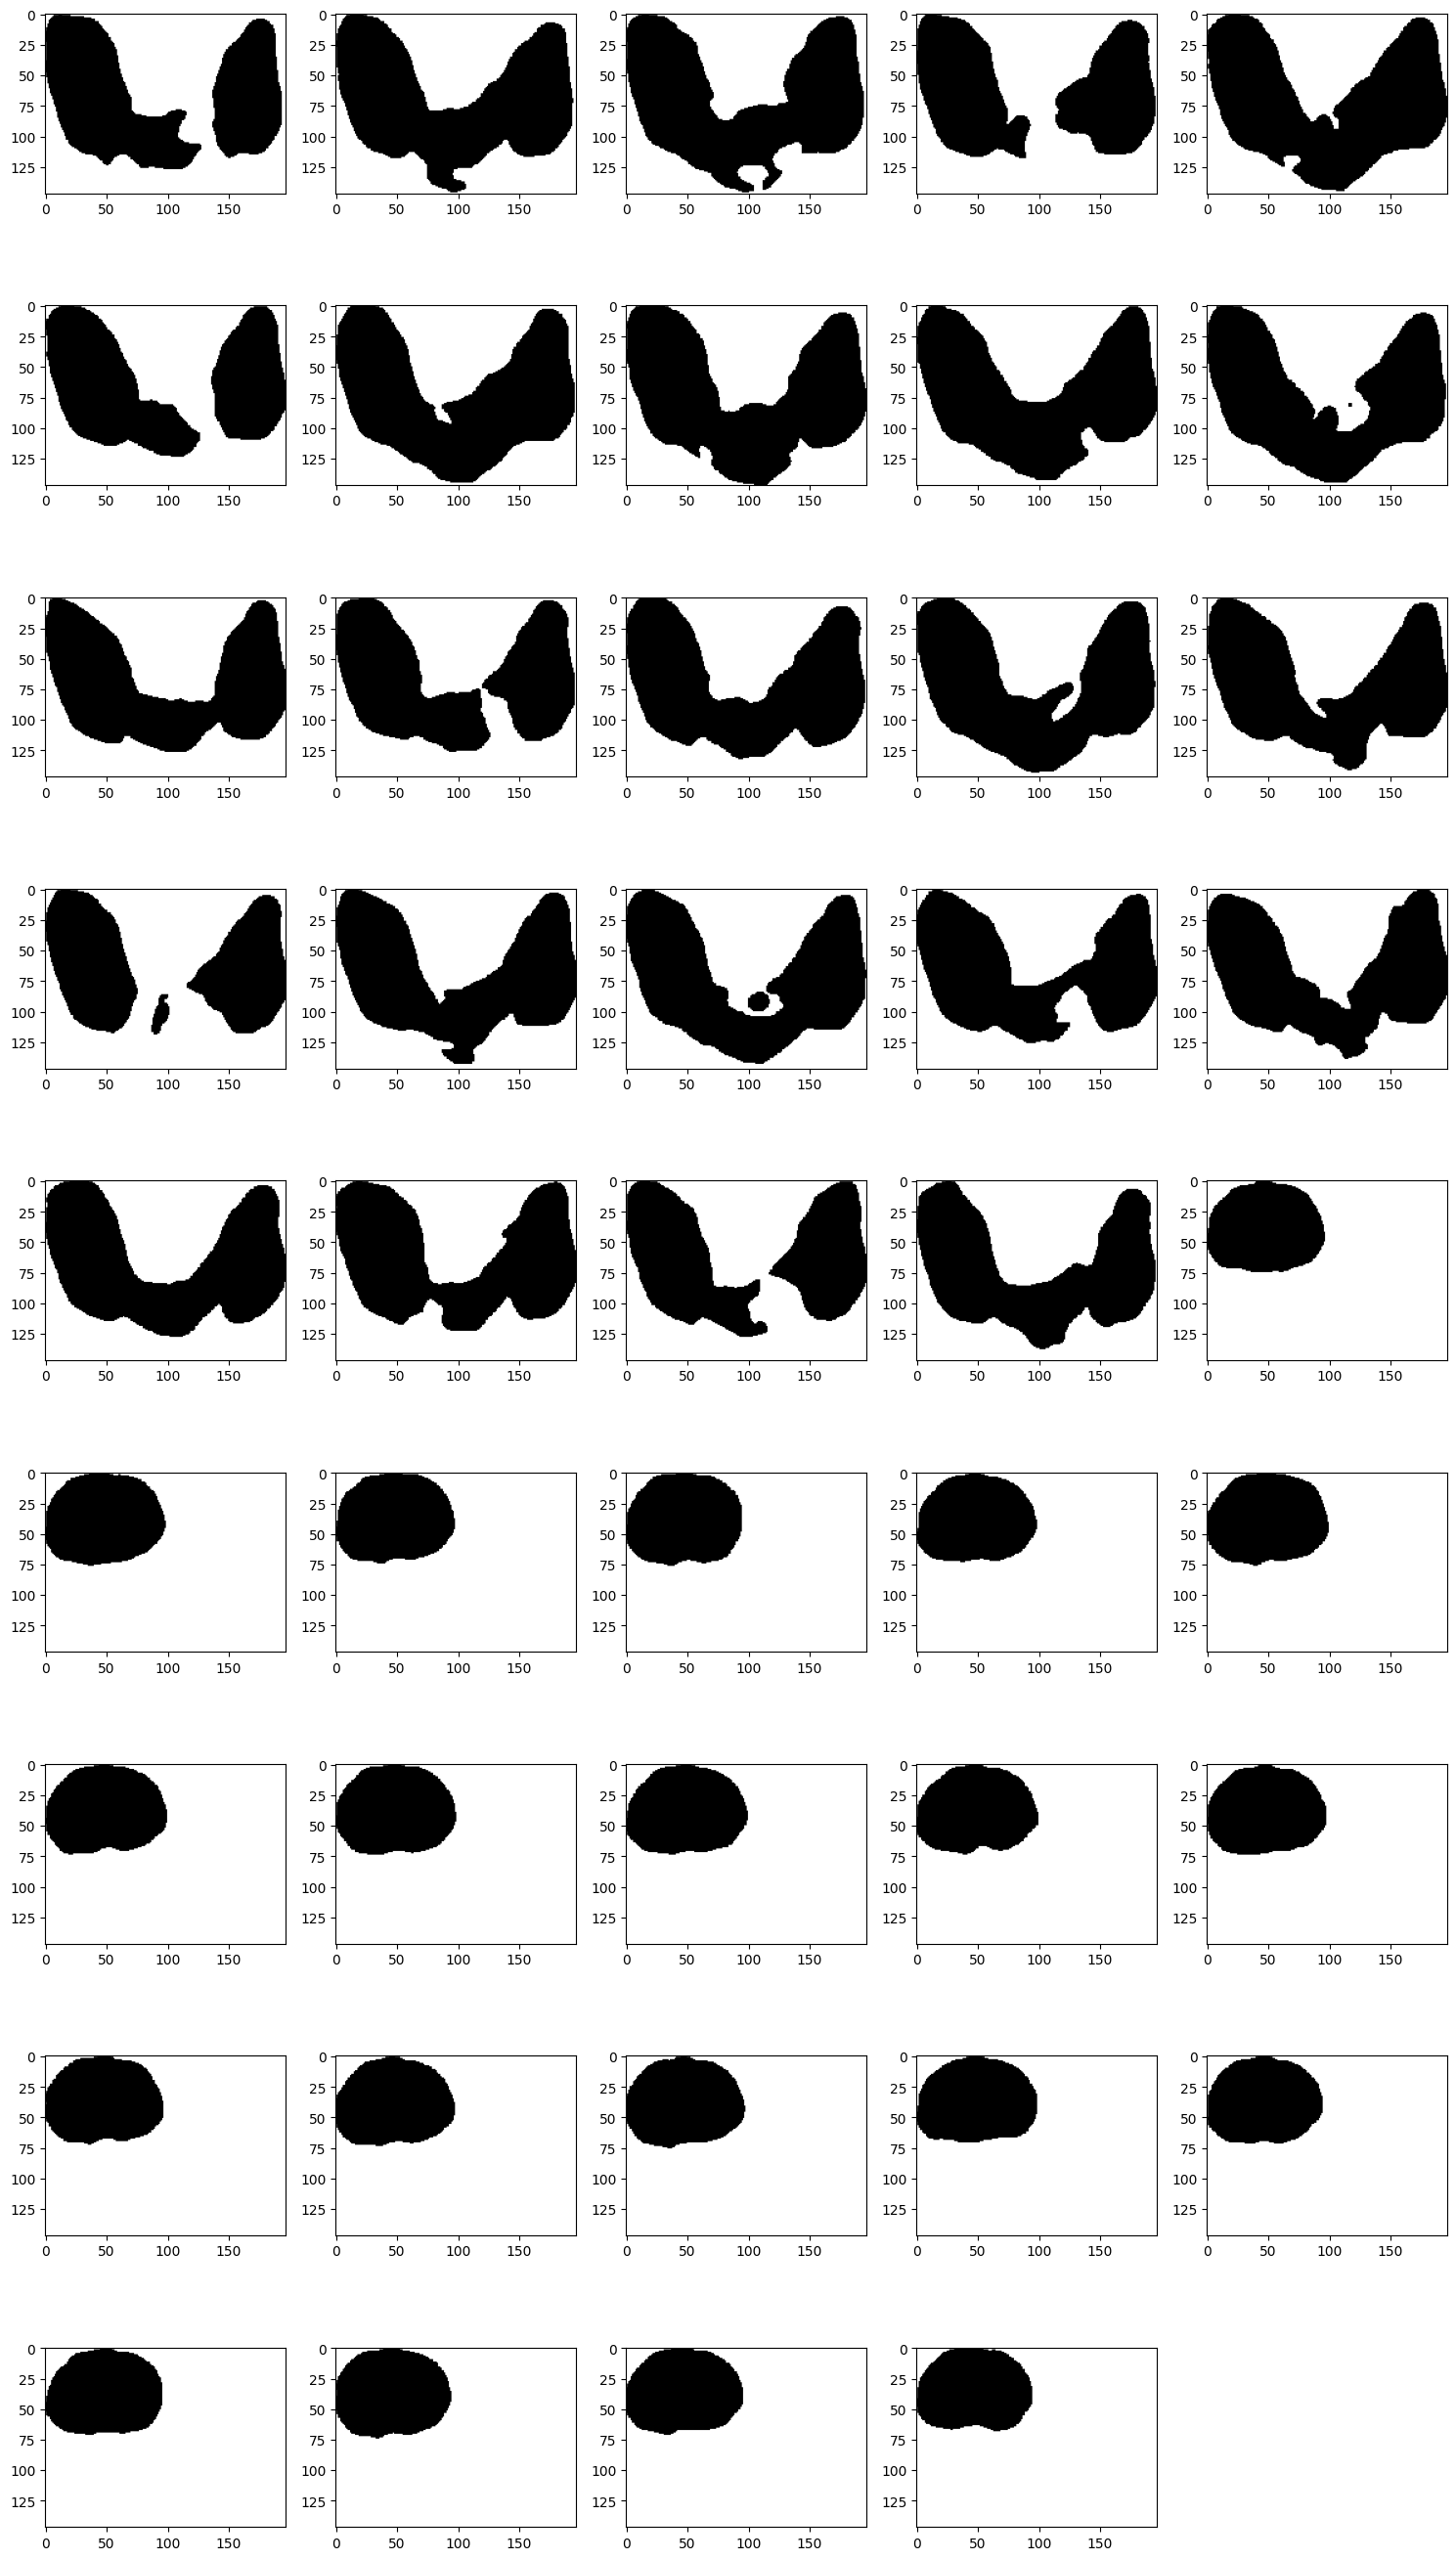

In [72]:
fig, axs = plt.subplots(9,5,figsize=(15,27))


MAX_X=np.max(BINARY_2D_SIZE,axis=0)[1][1]
MAX_Y=np.max(BINARY_2D_SIZE,axis=0)[1][0]


for index, img in enumerate(BINARY_2D_IMAGES):
    ax=axs.flat[index]
    
    MIN_Y,MIN_X=BINARY_2D_SIZE[index][0]
    
    WIDTH_Y=BINARY_2D_SIZE[index][1][0]

    # contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # img = img[MIN_Y:MIN_Y+WIDTH_Y,MIN_X:MIN_X+MAX_X]
    img = img[MIN_Y:MIN_Y+MAX_Y,MIN_X:MIN_X+MAX_X]
    BINARY_2D_IMAGES[index]=img
    
    # print(x, y, w, h)
    
    ax.imshow(img,cmap="binary")
    # plt.imsave(f'data/{index}.png', img, cmap="binary")
    # ax.axis("off")
    
fig.delaxes(axs[8][4])
fig.tight_layout()


In [18]:
BINARY_2D_CENTER, BINARY_2D_SIZE= calculate_image_detail(BINARY_2D_IMAGES,1)

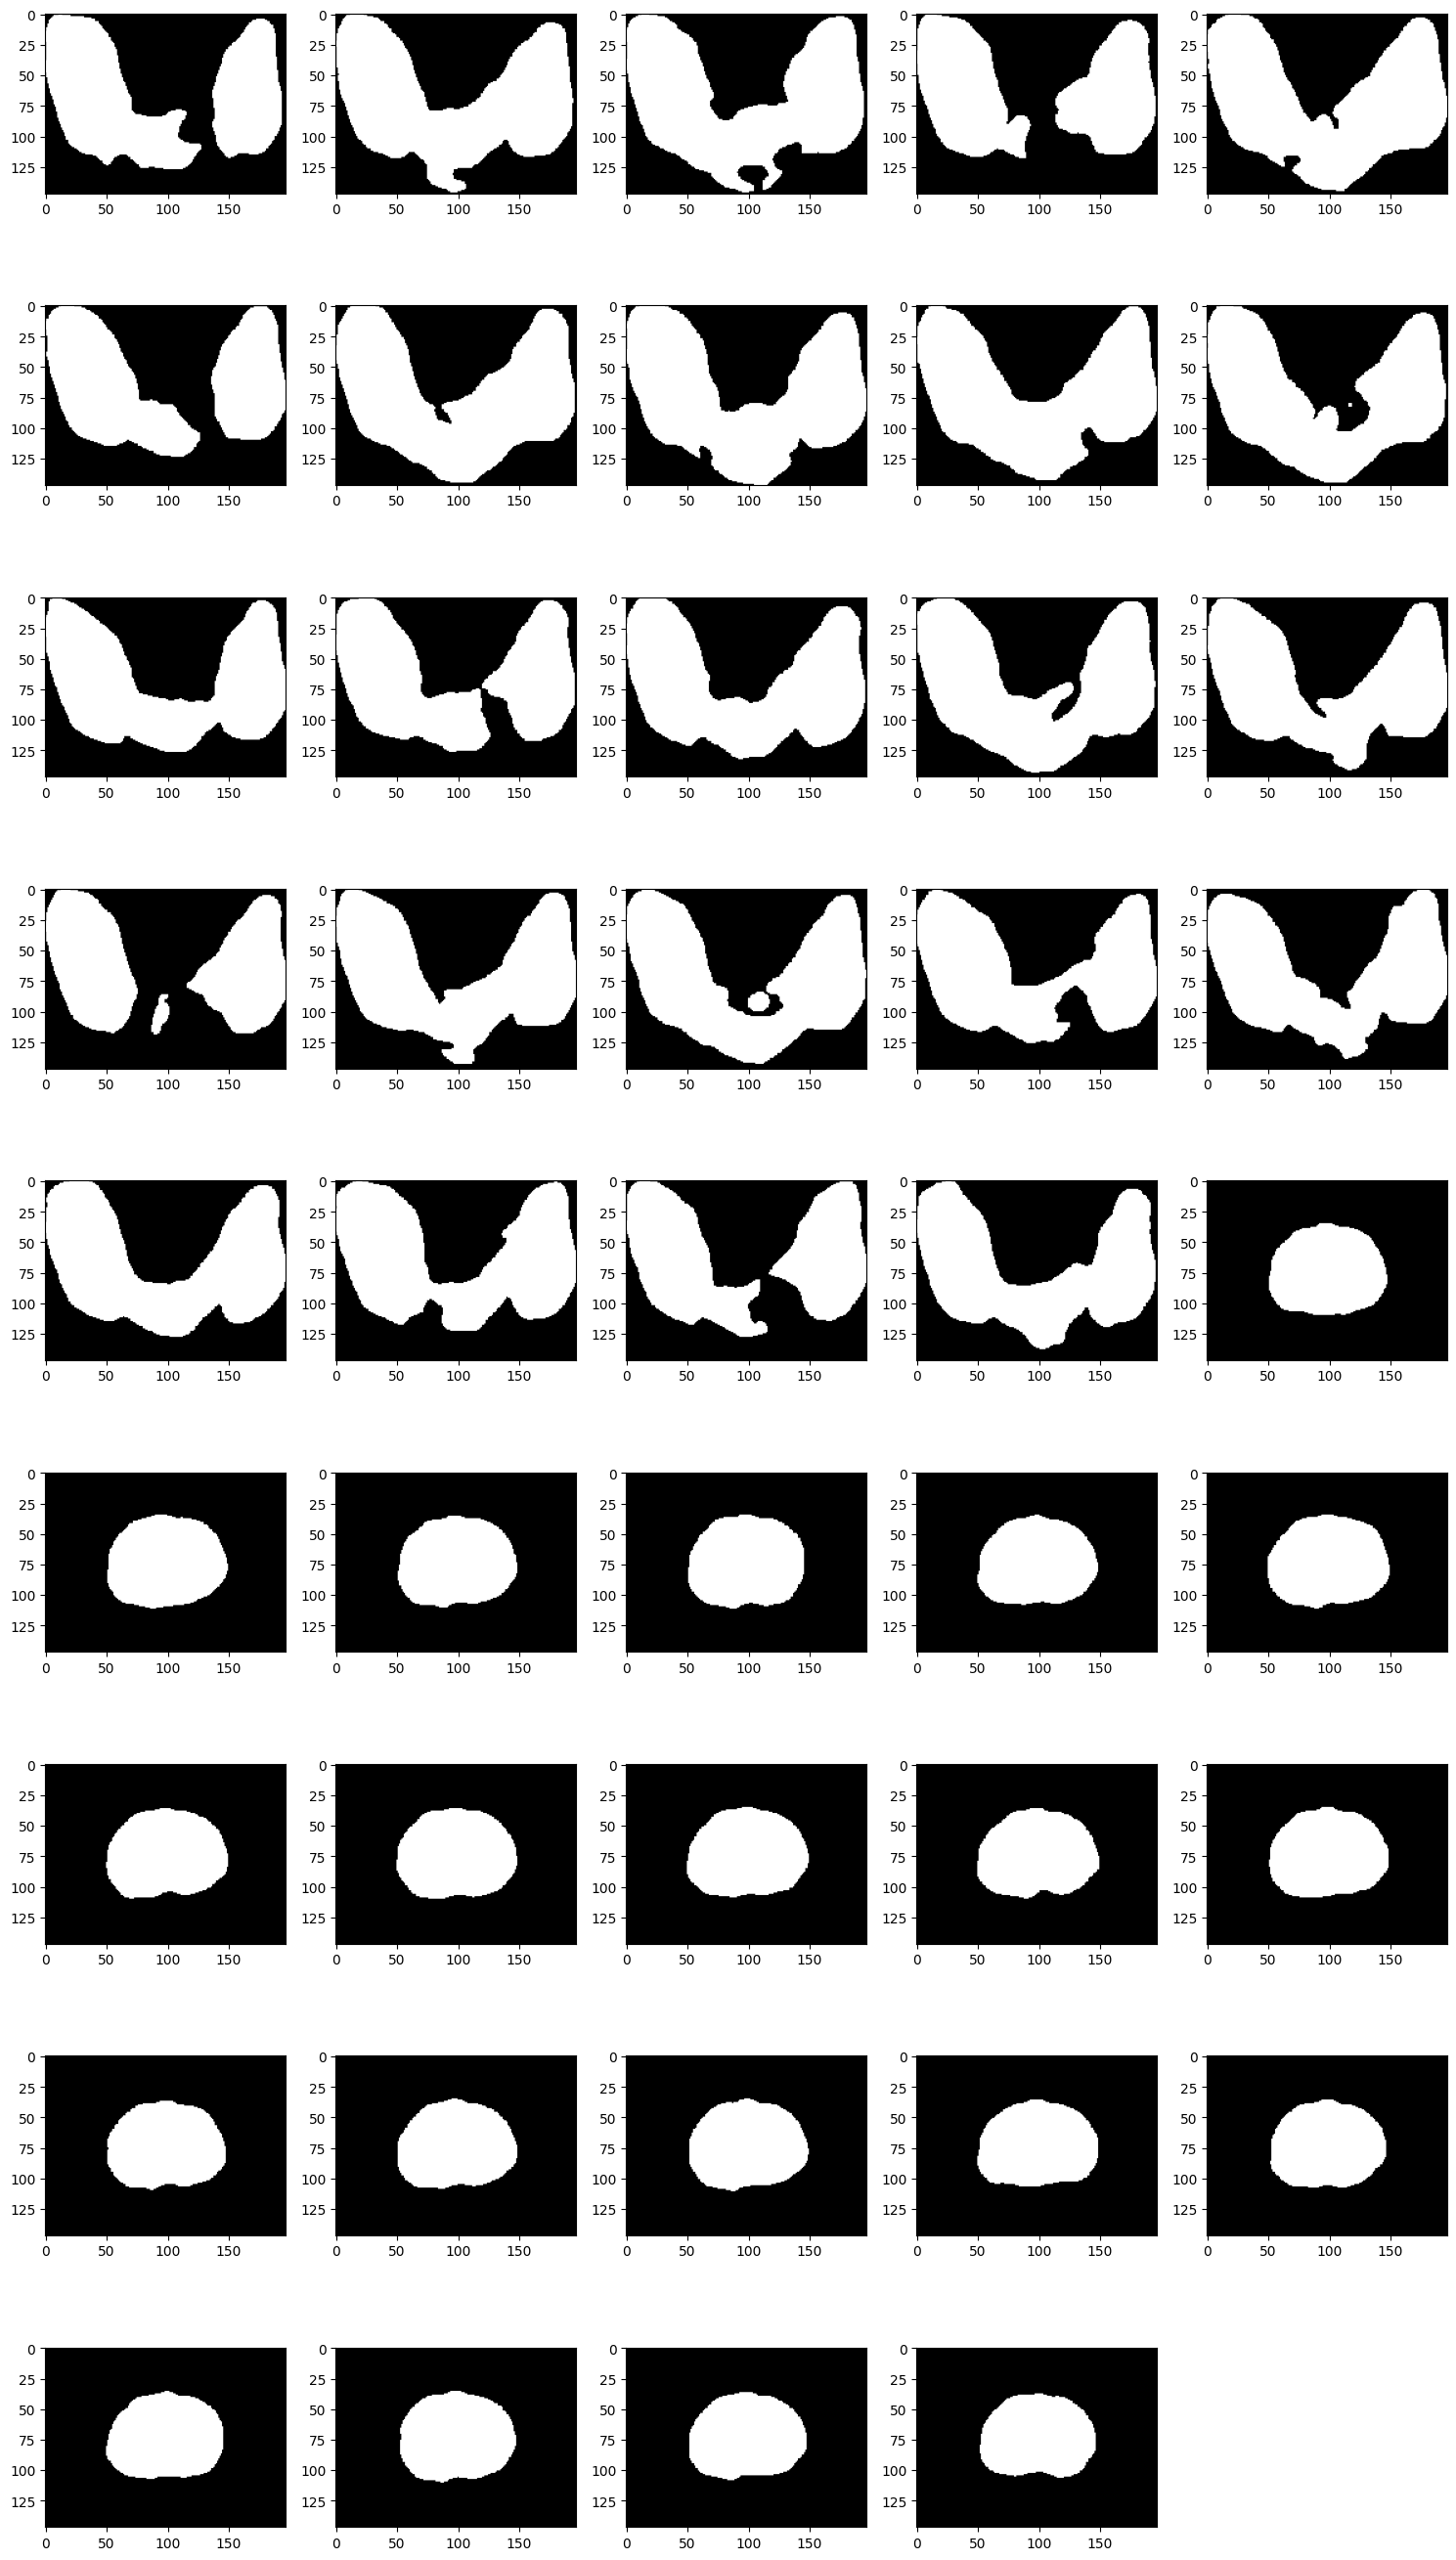

In [84]:
fig, axs = plt.subplots(9,5,figsize=(15,27))

for index, img in enumerate(BINARY_2D_IMAGES):
    ax=axs.flat[index]
    
    if index>23:
        
        # ref_img, new_img, disparity = procrustes(BINARY_2D_IMAGES[1], img)
        
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            contour = contours[0]  # Assuming there is only one contour
            M = cv2.moments(contour)
            centroid_x = int(M['m10'] / M['m00'])
            centroid_y = int(M['m01'] / M['m00'])
            
            # Get the dimensions of the image
            height, width = img.shape
            
            # Calculate the translation required to move the centroid to the center of the image
            translation_x = width // 2 - centroid_x
            translation_y = height // 2 - centroid_y
            
            # Apply the translation to the contour
            contour_centered = contour + [translation_x, translation_y]
            
            # Create a new binary image with the centered object
            new_img = np.zeros_like(img)
            cv2.drawContours(new_img, [contour_centered], -1, 1, thickness=cv2.FILLED)
        
            ax.imshow(new_img,cmap="gray")
        
    else:
        ax.imshow(img,cmap="gray")
    # ax.axis("off")
    
fig.delaxes(axs[8][4])
fig.tight_layout()


In [10]:
MARCHING_CUBE_POINTS={}
for key in PTV_SAMPLES.keys():
    mc=reducing_point_numbers(PTV_SAMPLES[key][0])
    # mc.show_march_cube(mc.get_mc_image())
    mc.calculate_decimate(3,0.95)

    # print(type(mc.get_mc_mask()),mc.get_mc_mask().shape)
    MARCHING_CUBE_POINTS[key]=[mc.get_mc_mask(),mc.get_landmarks()]

    mc.get_landmarks()
    # MARCHING_CUBE_POINTS[key]=mc.get_new_image()

    #MARCHING_CUBE_POINTS[key]
    # mc.show_march_cube(mc.get_new_image())
    # print(mc.dc_dice())

2023-12-27 08:54:11.738 (  74.168s) [          5EBDD9]      vtkDelaunay3D.cxx:514   WARN| vtkDelaunay3D (0x1150598d0): 140 degenerate triangles encountered, mesh quality suspect
2023-12-27 08:54:30.681 (  93.112s) [          5EBDD9]      vtkDelaunay3D.cxx:514   WARN| vtkDelaunay3D (0x29781bfe0): 21 degenerate triangles encountered, mesh quality suspect


In [11]:
# PTV_SAMPLES=orignal_data_ob.get_PTV_IMAGES()
# CT_SAMPLES=orignal_data_ob.get_CT_SCAN_IMAGES()

# reading_orignal_data.saveImage("Output/","PTV_",PTV_SAMPLES)
# reading_orignal_data.saveImage("Output/","CT_",CT_SAMPLES)

In [12]:
# mc=reducing_point_numbers(PTV_SAMPLES[0])
# mc.show_march_cube(mc.get_mc_image())

# mc.calculate_decimate(3,0.9)
# mc.show_march_cube(mc.get_new_image())

In [13]:
def numpy_to_sitk(IMG):
    image_sitk = sitk.GetImageFromArray(IMG)
    image_sitk.SetOrigin((0, 0, 0))
    return image_sitk
    # spacing.reverse()
    # image_sitk.SetSpacing(spacing)

In [14]:
# fixed_mask  = np.array(MARCHING_CUBE_POINTS["Pacjent_01_anonymized"].swapaxes(0, 1).swapaxes(1, 2).astype(np.float32))
# moving_mask = PTV_SAMPLES["Pacjent_01_anonymized"][1].swapaxes(0, 1).swapaxes(1, 2).astype(np.float32)


# print(type((fixed_mask)),type(moving_mask))
# print(fixed_mask.shape,moving_mask.shape)

# registration(moving_mask,fixed_mask).get_warped_moving_mask()

In [15]:
# p = pv.Plotter(notebook=True)
# p.add_mesh(moving_mask, color="tan", show_edges=False)
# p.show()

In [16]:
# res_1 = sitk.GetArrayFromImage(sitk.Resample( numpy_to_sitk(moving_mask), numpy_to_sitk(fixed_mask),interpolator=sitk.sitkNearestNeighbor))
# res_2 = sitk.GetArrayFromImage(sitk.Resample(numpy_to_sitk(fixed_mask)  , numpy_to_sitk(moving_mask), interpolator=sitk.sitkNearestNeighbor))


# print(moving_mask.shape,fixed_mask.shape,res_1.shape)
# print(moving_mask.shape,fixed_mask.shape,res_2.shape)

In [ ]:
# REGISTRATION_POINTS={}
for key in PTV_SAMPLES.keys():
    # REGISTRATION_POINTS[key]=[]
    for index,frak in enumerate(PTV_SAMPLES[key]):
        try:
            # Take the best result for marching cube, for now it is static but I will make it dynamic
            fixed_mask  = MARCHING_CUBE_POINTS["Pacjent_01_anonymized"][0].swapaxes(0, 1).swapaxes(1, 2).astype(np.float32)
            
            # fixed_mask = sitk.GetArrayFromImage(sitk.Resample(numpy_to_sitk(fixed_mask)  , numpy_to_sitk(moving_mask), interpolator=sitk.sitkNearestNeighbor))

            
            moving_mask =  frak.swapaxes(0, 1).swapaxes(1, 2).astype(np.float32)
            #reshaping the moving mask
            moving_mask = sitk.GetArrayFromImage(
                sitk.Resample( numpy_to_sitk(moving_mask), numpy_to_sitk(fixed_mask),interpolator=sitk.sitkNearestNeighbor)
            )
            tfm=registration(fixed_mask,moving_mask).get_tfm()


            landmarks=MARCHING_CUBE_POINTS["Pacjent_01_anonymized"][1]
            moving_mask=numpy_to_sitk(np.array(moving_mask))

            REGISTRATION_POINTS=[]
            for i in range(landmarks.shape[0]):
                point = (int(landmarks[i][2]),int(landmarks[i][1]),int(landmarks[i][0]))
 
                physLoc = moving_mask.TransformIndexToPhysicalPoint(point)
                res = tfm.TransformPoint(physLoc)
                
                REGISTRATION_POINTS.append((int(res[2]),int(res[1]),int(res[0])))


            with open(f'./POINTS_1/{key}_{index}.json', 'w') as f:
                json.dump(REGISTRATION_POINTS, f)

            # All results goes to REGISTRATION_POINTS variables but for now I save them in different files
            # REGISTRATION_POINTS[key].append()
        except:
            pass
            #print((MARCHING_CUBE_POINTS[key]).shape,frak.shape)
     
        

In [27]:
# To check if the results of the files are equal

file_1 = './POINTS/Pacjent_01_anonymized_0.json'
file_2 = './POINTS/Pacjent_01_anonymized_1.json'

# Load JSON data from file
with open(file_1, 'r') as file:
    data_1 = json.load(file)

with open(file_2, 'r') as file:
    data_2 = json.load(file)

array_1 = np.array(data_1)
array_2 = np.array(data_2)

print(np.array_equal(array_1,array_2),np.allclose(array_1,array_2))

True True


(699, 142, 657, 3)
328


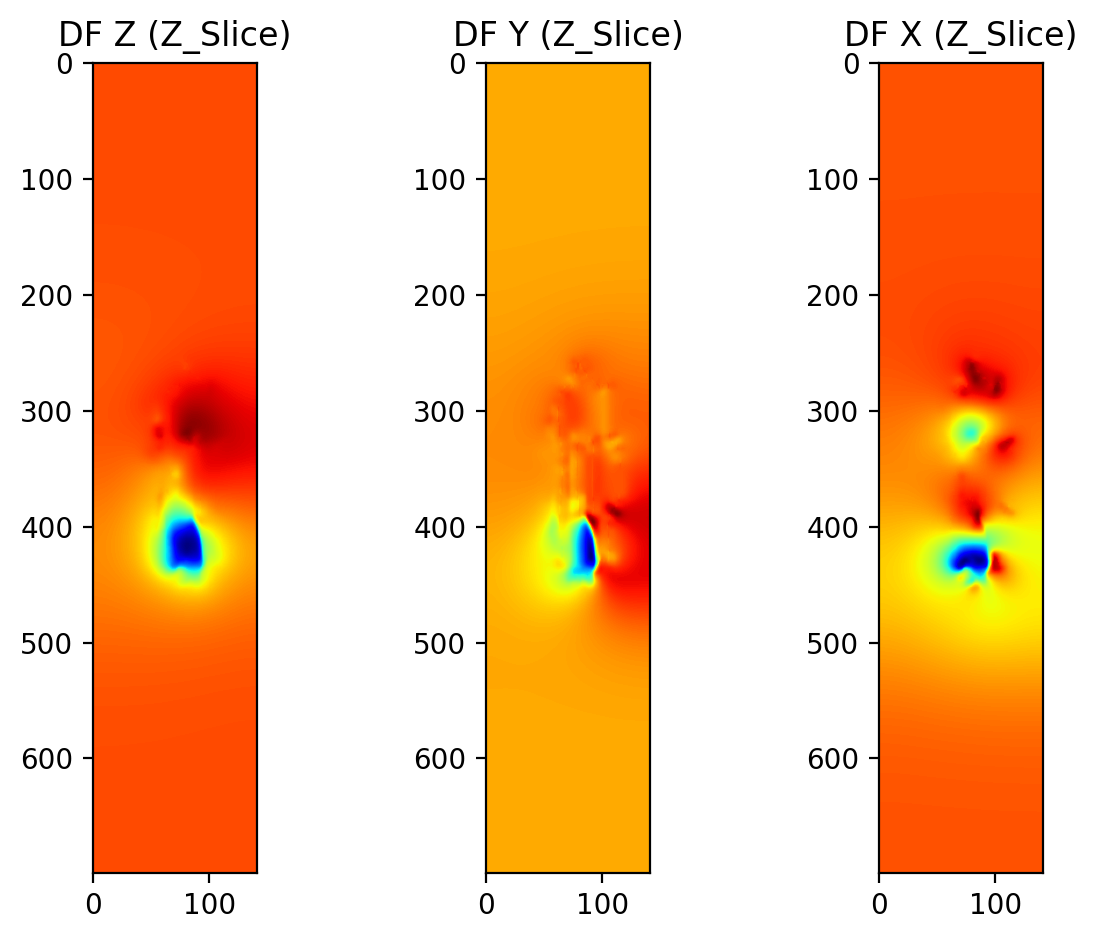

In [ ]:
output_image=REGISTRATION_POINTS["Pacjent_02_anonymized"][1][0]

z_slice = output_image.shape[2] // 2 

print(output_image.shape)
print(z_slice)

registration.show_fig(
    [output_image[:, :, z_slice, 0],output_image[:, :, z_slice, 1],output_image[:, :, z_slice, 2]],
    ["DF Z (Z_Slice)","DF Y (Z_Slice)","DF X (Z_Slice)"]
)